In [2]:
import numpy as np
from matplotlib import pyplot as plt
import os
import glob
%matplotlib inline
from scipy.stats import zscore
import imp
# modules
import decoders, utils, tuning, learning, mainfigs, suppfigs

### WHERE YOU DOWNLOADED THE FIGSHARE
dataroot = 'Z:/releases/stringer-et-al-2019a/fs125'

# file list
db = np.load(os.path.join(dataroot, 'database.npy'), allow_pickle=True)
fs = []
for di in db:
    mname = di['mouse_name']
    datexp = di['date']
    blk = di['block']
    stype = di['expt']
    
    fname = '%s_%s_%s_%s.npy'%(stype, mname, datexp, blk)
    fs.append(os.path.join(dataroot, fname))

### WHERE YOU WANT TO SAVE THE OUTPUTS OF THE ANALYSIS SCRIPTS AND THE FIGURES (if save_figure=True)
saveroot = 'D:\DATA\stringer-etal2019'

In [32]:
f = fs[0]
dat = np.load(f, allow_pickle=True).item()
sresp, istim, itrain, itest = utils.compile_resp(dat, npc=32)

x = sresp[:, itrain]
y = istim[itrain]
NN, NT = np.shape(sresp)


In [6]:
th_range = np.arange(0, 2*np.pi, 2*np.pi/360)
rcos = np.cos(th_range)
rsin = np.sin(th_range)

def log_prob(a):
    atx = a[0].T @ x
    btx = a[1].T @ x
    
    Z = atx * rcos[:, np.newaxis] + btx * rsin[:, np.newaxis]
    Zmax = np.max(Z, axis=0)
    
    Z = np.exp(Z-Zmax)
    Zsum = np.sum(Z,axis=0)

    logL = np.mean(atx * np.cos(y) + btx * np.sin(y) - np.log(Zsum) - Zmax)

    Zcos = rcos.T @ Z / Zsum
    Zsin = rsin.T @ Z / Zsum
    
    da = (x @ (np.cos(y) - Zcos))#/x.shape[1]
    db = (x @ (np.sin(y) - Zsin))#/x.shape[1]
    
    return logL, np.stack((da,db))
    
    

In [29]:
a = np.random.randn(2, NN)/1e7 # initializdr with very small values

eps0 = 0.05 # learning rate
niter = 501
lam = .0 # regularization parameter, makes fitting unstable

logL = np.zeros(niter,)
pa = np.zeros(a.shape)

for it in range(niter):    
    logL[it], da = log_prob(a)
    
    pa = .95 * pa + .05 * (da - lam * a)
    
    if it<20:
        eps = eps0/(20-it)
    a += eps * pa    
    
    if it%100==0:
        print(logL[it])


-5.886107559374568
-0.4387410879499554
-0.16913275074296877
-0.15764865463476466
-0.15310199531616198
-0.14904430211714798


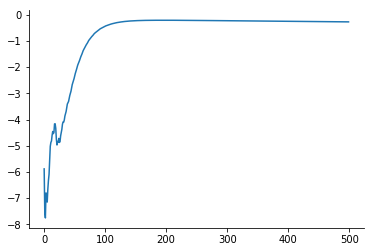

In [27]:
plt.plot(logL[:it])

In [30]:
dx = a[0].T @ sresp[:, itest]
dy = a[1].T @ sresp[:, itest]

apred = np.angle(dx + 1j * dy)
apred[apred<0] = apred[apred<0] + 2*np.pi

nangle = 2*np.pi
error = istim[itest] - apred
error = np.remainder(error, nangle)
error[error > nangle/2] = error[error > nangle/2] - nangle

np.median(np.abs(error)) * 180/np.pi

2.149023215611123

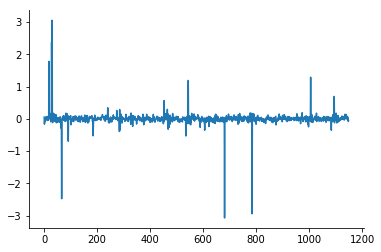

In [31]:
plt.plot(error)